# JumpStart: Tabular Classification using XGBoost and Linear Learner

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). 

In this demo notebook, we demonstrate how to use the JumpStart API for tabular data classification using two popular algorithms: [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). Tabular classification is the task of assigning a class to an example of structured or relational data. The JumpStart API for tabular classification can be used for classification of an example in two classes (binary classification) or more than two classes (multi-class classification).


In this notebook, we demonstrate two use cases of tabular classification models:

* How to train a tabular model on an example dataset to do multi-class classification.
* How to use the trained tabular model to perform inference, i.e., classifying new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on MNIST Dataset](#2.-Train-a-Tabular-Model-on-MNIST-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Start Training](#2.3.-Start-Training)
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.



---
To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Train a Tabular Model on MNIST Dataset

---
In this demonstration, we will train a tabular algorithm on the
[MNIST](http://yann.lecun.com/exdb/mnist/) dataset. 
The dataset contains examples of individual pixel values from each 28 x 28 grayscale image to predict the digit label of 10 classes {0, 1, 2, 3, ..., 9}. The MNIST dataset is downloaded from [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/). 

Below is the screenshot of the first 5 examples in the MNIST dataset. 

![test_data_head.jpg](https://jumpstart-cache-prod-us-west-2.s3-us-west-2.amazonaws.com/catboost-metadata/assets/classification_mnist_testset_head.png) 

If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/' and 'validation/' (optional). Each sub-directory contains a 'data.csv' file (The MNIST dataset used in this example has been prepared and saved in `training_dataset_s3_path` shown below).
* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data. 

>Note. For [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), the validation data is used to compute a validation score at the end of entire training process. There is no early stopping in the training process for scikit-learn linear model. If the validation data is not provided, the corresponding validation scores are not computed. 

* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).

* For the training and validation data, all the categorical features must be encoded as numerical values through encoding techniques such as the label encoding and one-hot encoding. The target must be encoded as numerical values by label encoding.  




Citations:

- [LeCun et al., 1998a] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. 'Gradient-based learning applied to document recognition.' Proceedings of the IEEE, 86(11):2278-2324, November 1998

### 2.1. Retrieve Training Artifacts
---
Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have two choices in this demonstration.
* [XGBoost](https://xgboost.readthedocs.io/en/latest/): To use this algorithm, specify `train_model_id` as `xgboost-classification-model` in the cell below.
* [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression): To use this algorithm, specify `train_model_id` as `sklearn-classification-linearlearner` in the cell below.

Note. [LightGBM](https://lightgbm.readthedocs.io/en/latest/) (`train_model_id: lightgbm-classification-model`) and [CatBoost](https://catboost.ai/en/docs/) (`train_model_id: catboost-classification-model`) are the other choices in the tabular classification category. Since they have different input-format requirements, please check a separate notebook `Amazon_JumpStart_Tabular_Classification_LightGBM_CatBoost.ipynb` for details.


---

In [3]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning. 
train_model_id, train_model_version, train_scope = "xgboost-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None, 
    framework=None,
    model_id=train_model_id, 
    model_version=train_model_version, 
    image_scope=train_scope, 
    instance_type=training_instance_type, 
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    model_scope=train_scope
)

### 2.2. Set Training Parameters

---
Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [4]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/tabular_multiclass/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [5]:
from sagemaker import hyperparameters
# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, 
    model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["num_boost_round"] = "500" # this hyperparameter is speficially for XGBoost
hyperparameters["early_stopping_rounds"] = "5"  # this hyperparameter is speficially for XGBoost
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '5', 'learning_rate': '0.3', 'gamma': '0', 'min_child_weight': '1', 'max_depth': '6', 'subsample': '1', 'colsample_bytree': '1', 'reg_lambda': '1', 'reg_alpha': '0'}


### 2.3. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [6]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name = training_job_name)

2022-03-11 02:52:07 Starting - Starting the training job...
2022-03-11 02:52:18 Starting - Launching requested ML instancesProfilerReport-1646967127: InProgress
.........
2022-03-11 02:54:00 Starting - Preparing the instances for training......
2022-03-11 02:55:02 Downloading - Downloading input data
2022-03-11 02:55:02 Training - Downloading the training image...
2022-03-11 02:55:29 Training - Training image download completed. Training in progress..[2022-03-11 02:55:31.406 ip-10-0-194-53.us-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-11:02:55:31:INFO] Imported framework sagemaker_xgboost_container.training
[2022-03-11:02:55:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-03-11:02:55:31:INFO] Invoking user training script.
[2022-03-11:02:55:31:INFO] Module transfer_learning does not provide a setup.py. 
Generating setup.py
[2022-03-11:02:55:31:INFO] Generating setup.cfg
[2022-03-11:02:55:31:INFO] Generating MANIFEST.in
[2022-0

## 3. Deploy and Run Inference on the Trained Tabular Model

---
In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others. Throughout the notebook, the examples are taken from the [MNIST](http://yann.lecun.com/exdb/mnist/) test set. 
The dataset contains examples of individual pixel values from each 28 x 28 grayscale image to predict the digit label of 10 classes {0, 1, 2, 3, ..., 9}.

We start by retrieving the jumpstart artifacts and deploy the `tabular_estimator` that we trained.

---

In [7]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, 
    model_version=train_model_version, 
    script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    enable_network_isolation=True,
)

-----!

---
Next, we download a hold-out MNIST test data from the S3 bucket for inference.

---

In [8]:
jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
test_data_prefix = "training-datasets/tabular_multiclass/test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name)

---
Next, we read the MNIST test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the MNIST test set. All of the test examples with features 
from ```Feature_1``` to ```Feature_784``` are sent into the deployed model to get model predictions, 
to estimate the ground truth ```Target``` column. For each test example, the model will output 
a vector of ```num_classes``` elements, where each element is the probability of the example for each class in the model. 
The ```num_classes``` is 10 in this case. Next, the predicted class label is obtained by taking the class label 
with the maximum probability over others. 
---

In [9]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)


Bad key text.latex.preview in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to 

The test dataset contains 10000 examples and 785 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_775,Feature_776,Feature_777,Feature_778,Feature_779,Feature_780,Feature_781,Feature_782,Feature_783,Feature_784
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, num_classes), where each row indicates 
the probability of the example for each class in the model. The num_classes is 10 in above test data. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

---

In [10]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    #endpoint_name = endpoint_name
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions['probabilities']
    return np.array(predicted_probabilities)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data. 
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(features.iloc[i:(i+batch_size), :].to_csv(header=False, index=False).encode("utf-8"))
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)
    

predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)  # Note. For binary classification, the model returns a array-like of shape (num_examples, 1), 
# where each row is the probability of the positive label 1, assuming there are positive label (encoded as 1) and negative label (encoded as 0) in the target.
# To get the probability for both label 0 and 1, execute following code:
# predict_prob = np.vstack((1.0 - predict_prob, predict_prob)).transpose() 

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

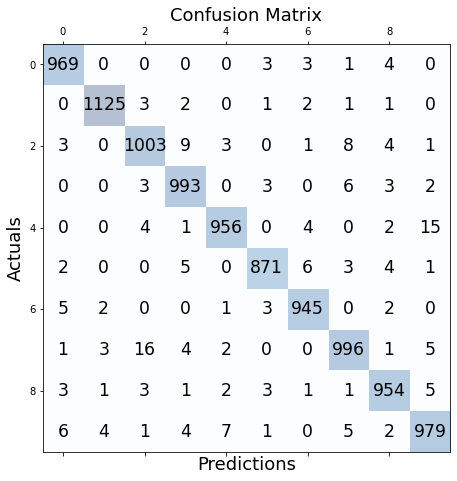

In [11]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [12]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.9791
F1 Macro: 0.9790257008913825
F1 Micro: 0.9791



---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [13]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()